In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# support arabic plotting
import arabic_reshaper # pip install arabic-reshaper
from bidi.algorithm import get_display # pip install python-bidi

# make a function to plot arabic labels
def plot_arabic(labelsSeries: pd.Series):
    """
    A function that plots arabic literals in their required format instead of just floating letters
    \nArgs:
     - labelsSeries: a series of arabic labels 
    \nReturns:
     - result: a list of properly formatted arabic labels
    """

    # apply the reshaping method
    arabicLabels = labelsSeries.apply(arabic_reshaper.reshape)

    # initiate the formatting process
    result = []
    for label in arabicLabels:
        result.append(get_display(label))
    
    # return the formatted labels as a list if there are more than one value
    if len(result) == 1:
        return result[0]
    else:
        return result

In [4]:
import numpy as np
import pandas as pd
import datetime
import json
import plotly.express as px
import geopandas as gpd 

map_df = gpd.read_file("../../data/riyadh.geojson")

with open(r"../../data/riyadh_districts.json", 'r', encoding='utf8', errors='ignore') as file:
    neighborhood = json.load(file)

# getting arabic district names from neighborhood file
ar_name = []
en_name = []
for i in range(len(neighborhood)):
    ar_name.append(neighborhood[i]["name_ar"])
    en_name.append(neighborhood[i]["name_en"])

district_df = pd.DataFrame(ar_name, columns=['name_ar'])
district_df["name_en"] = en_name

map_df = map_df.merge(district_df, left_on=["name"], right_on=["name_en"])

apartments = pd.read_csv("../../data/apartments_sale_riyadh_cleaned.csv")

apartments = apartments[['price', 'beds', 'livings', 'wc', 'area', 
               'street_width', 'age', 'ketchen', 
               'furnished', 'district', 'width',
               'length', 'advertiser_type', 'longitude', 'latitude']]

apartments = apartments.groupby(['district'], as_index=False).mean()

apartments["district"] = apartments["district"].apply(lambda x: x.strip())

merged_df = map_df.merge(apartments, left_on=["name_ar"], right_on=["district"])

geo_df = merged_df.set_index("district")

def make_plot(geo_df, color):
    fig = px.choropleth_mapbox(geo_df,
                            geojson=geo_df.geometry,
                            locations=geo_df.index,
                            color=color,
                            center={"lat": 24.79, "lon":46.70},
                            opacity=0.3, 
                            color_continuous_scale='darkmint',
                            mapbox_style="carto-positron",
                            zoom=8,
                            title="متوسط أسعار الشقق حسب الحي (الرياض)",
                            hover_data={'price':':.0f'})
    fig.show()


make_plot(geo_df, "price")

In [9]:
apartments = pd.read_csv("../../data/apartments_sale_riyadh_cleaned.csv")
data_wo_exteremevalues = apartments[(apartments['area'] < 1000) & (apartments['price'] < 3000000)]

In [13]:
px.scatter(data_wo_exteremevalues, x="area", y="price", color='age',
           opacity=0.2, title="توزيع أسعار الشقق حسب عمر المسكن")

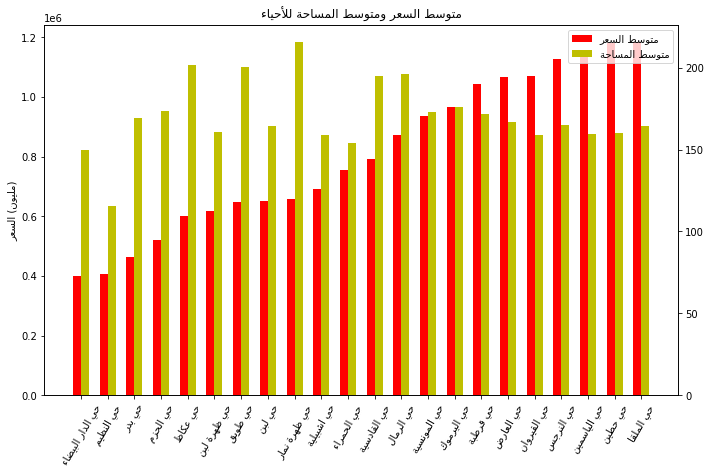

In [19]:
#| fig-cap: Average price and area per distrit for Jeddah and Riyadh

from IPython import display
small_apartments = apartments[apartments['area'] < 80000]

district_counts = small_apartments.district.value_counts()
repeated = set(district_counts[district_counts > 50].index.values)
d_district = small_apartments[small_apartments.district.isin(repeated)]

avg_size_dist = d_district.groupby(['district'])[['area', 'price']].mean().reset_index().sort_values('price')
sorted_districts = avg_size_dist.query("area < 600")

plt.figure(figsize=(20,15))

x = np.arange(len(sorted_districts))
ax1 = plt.subplot(2,2,1)
w = 0.3
plt.title(plot_arabic(pd.Series('متوسط السعر ومتوسط المساحة للأحياء')))
plt.xticks(x + w /2, plot_arabic(sorted_districts['district']), rotation='60')
P =ax1.bar(x, sorted_districts['price'], width=w, color='r', align='center')
plt.ylabel(plot_arabic(pd.Series("(مليون) السعر")))
ax2 = ax1.twinx()
S =ax2.bar(x + w, sorted_districts['area'], width=w,color='y',align='center')

plt.legend([P, S], plot_arabic(pd.Series(['متوسط السعر', 'متوسط المساحة'])))

**Covariance: What is the factor that when present increases the price the most?**

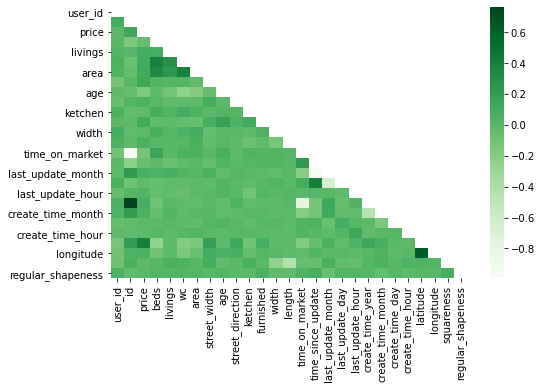

In [23]:
#| fig-cap: "Covariance Heatmap"
apartments.drop(columns='last_update_year', inplace=True)
mask = np.triu(np.ones_like(apartments.corr()))
corr = apartments.corr()
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(ax=ax, data= apartments.corr(), cmap="Greens",mask=mask);

We can see by looking at the heatmap that the attributes that influence the price the most are: 
- 'area' 
- 'longitude' 
- 'latitude' 
- 'number of rooms'

A deeper look at some interesting attributes:

Index(['user_id', 'id', 'price', 'beds', 'livings', 'wc', 'area',
       'street_width', 'age', 'street_direction', 'ketchen', 'furnished',
       'district', 'width', 'length', 'advertiser_type', 'city_side',
       'district_en', 'time_on_market', 'time_since_update',
       'last_update_year', 'last_update_month', 'last_update_day',
       'last_update_hour', 'create_time_year', 'create_time_month',
       'create_time_day', 'create_time_hour', 'latitude', 'longitude',
       'squareness', 'regular_shapeness'],
      dtype='object')


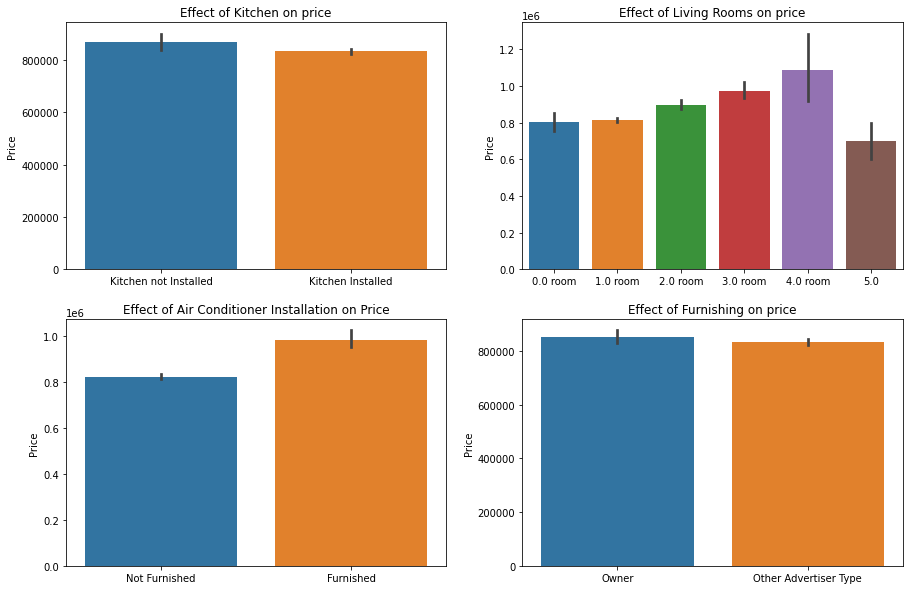

In [33]:
#| label: featureplots
#| fig-cap: Visualizing the effect of the 4 features on the price
# see how great the above 4 feature affect the price
data = pd.read_csv("../../data/apartments_sale_riyadh_cleaned.csv")
print(data.columns)
# creating the canvas
fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2,2, figsize=(15,10))
# plotting ax1 data: `kitchen`
ax1 = sns.barplot(ax=ax1, y=data["price"], x=data["ketchen"] ,data=data)
# configure the plot
ax1.set_title("Effect of Kitchen on price")
ax1.set_xlabel("")
labels = [item.get_text() for item in ax1.get_xticklabels()]
labels[0] = "Kitchen not Installed"
labels[1] = "Kitchen Installed"
ax1.set_xticklabels(labels)
ax1.set_ylabel("Price")
# plotting ax2 data: `livings`
ax2 = sns.barplot(ax=ax2, y=data["price"], x=data["livings"] ,data=data)
# configure the plot
ax2.set_title("Effect of Living Rooms on price")
ax2.set_xlabel("")
labels = [item.get_text() for item in ax2.get_xticklabels()]
labels[0] = f"{labels[0]} room"
labels[1] = f"{labels[1]} room"
labels[2] = f"{labels[2]} room"
labels[3] = f"{labels[3]} room"
labels[4] = f"{labels[4]} room"
ax2.set_xticklabels(labels)
ax2.set_ylabel("Price")
# plotting ax3 data: `ac`
ax3 = sns.barplot(ax=ax3, y=data["price"], x=data["furnished"] ,data=data)
# configure the plot
ax3.set_title("Effect of Air Conditioner Installation on Price")
ax3.set_xlabel("")
labels = [item.get_text() for item in ax3.get_xticklabels()]
labels[0] = "Not Furnished"
labels[1] = "Furnished"
ax3.set_xticklabels(labels)
ax3.set_ylabel("Price")

# plotting ax4 data: `advertiser_type`
ax4 = sns.barplot(ax=ax4,y=data["price"], x=data["advertiser_type"].apply(lambda x: 0 if x == "owner" else 1), data=data)
# configure the plot
ax4.set_title("Effect of Furnishing on price")
ax4.set_xlabel("")
labels = [item.get_text() for item in ax4.get_xticklabels()]
labels[0] = "Owner"
labels[1] = "Other Advertiser Type"
ax4.set_xticklabels(labels)
ax4.set_ylabel("Price");